# SQL Initiation

Before starting, you need to install the following packages:
- duckdb
- sqlalchemy
- pandas
- seaborn
- jupyter
- matplotlib
And download the following files (filter by date starting from 2012-12-31 and ending at 2022-05-31):
- [eco2mix](https://odre.opendatasoft.com/explore/dataset/eco2mix-regional-tr/information/?disjunctive.libelle_region&disjunctive.nature)
- [synop](https://public.opendatasoft.com/explore/dataset/donnees-synop-essentielles-omm/table/?sort=date)

The working data being expressed in French, the various modifications applied to them keep the same language.

## 1. Data loading and cleaning

### Imports and configuration

In [1]:
# SQL libraries import
import duckdb
import sqlalchemy

# Storage libraries import
import pandas as pd

# Mathematics libraries import
import math

# Visualisation libraries import
import seaborn as sns
import matplotlib.pyplot as plt

# Reload the SQL extension
%reload_ext sql

# Set configrations on ipython-sql to directly output data to Pandas and to simplify the output that is printed to the notebook.
%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

# Connection using SQLAchemy (be careful not to have spaces or special characters in the pwd)
%sql duckdb:///eco2mix.db
#%sql duckdb:///:memory:

### Dataframe cleaning

In [2]:
# Pandas dataframe creation
eco_2_mix_df = pd.read_csv("eco2mix-regional-cons-def.csv", sep=";")

# Useless columns deletion
eco_2_mix_df = eco_2_mix_df.drop(["Date", "Heure", "Column 30"], axis=1)

# Suppression des colonnes ayant au moins 80% de valeurs nulles (obtenues par un SUMMARIZE SELECT * FROM DF)
eco_2_mix_df = eco_2_mix_df.drop(["Stockage batterie",
         "Déstockage batterie",
         "Eolien terrestre",
         "Eolien offshore"
        ], axis=1)

# First 10 000 rows selection (to enhance performance)
#eco_2_mix_df = eco_2_mix_df.head(10000)

# Addition of a column corresponding to the total instantaneous production
eco_2_mix_df["Production instantanée"] = eco_2_mix_df["Thermique (MW)"] + eco_2_mix_df["Nucléaire (MW)"] + eco_2_mix_df["Eolien (MW)"] + eco_2_mix_df["Solaire (MW)"] + eco_2_mix_df["Pompage (MW)"] + eco_2_mix_df["Bioénergies (MW)"] + eco_2_mix_df["Ech. physiques (MW)"]

# Recalcul des TCO
eco_2_mix_df["TCO Thermique (%)"] = eco_2_mix_df["Thermique (MW)"] / eco_2_mix_df["Production instantanée"] * 100
eco_2_mix_df["TCO Nucléaire (%)"] = eco_2_mix_df["Nucléaire (MW)"] / eco_2_mix_df["Production instantanée"] * 100
eco_2_mix_df["TCO Eolien (%)"] = eco_2_mix_df["Eolien (MW)"] / eco_2_mix_df["Production instantanée"] * 100
eco_2_mix_df["TCO Solaire (%)"] = eco_2_mix_df["Solaire (MW)"] / eco_2_mix_df["Production instantanée"] * 100
eco_2_mix_df["TCO Hydraulique (%)"] = eco_2_mix_df["Hydraulique (MW)"] / eco_2_mix_df["Production instantanée"] * 100
eco_2_mix_df["TCO Bioénergies (%)"] = eco_2_mix_df["Bioénergies (MW)"] / eco_2_mix_df["Production instantanée"] * 100

# Delete the SQL table if it already exists
%sql DROP TABLE IF EXISTS eco_2_mix_table CASCADE;

# Transformation of the dataframe into a SQL table
%sql CREATE TABLE eco_2_mix_table AS (SELECT * FROM eco_2_mix_df);

# Conversion of character string (ISO 8601) to SQL Timestamp
%sql ALTER TABLE eco_2_mix_table ALTER COLUMN \"Date - Heure\" TYPE TIMESTAMP;

# Deletion of lines with zero consumption (those of the first reading)
%sql delete from eco_2_mix_table where \"Consommation (MW)\" is null

,Count
0,12


### Dataframe display

In [3]:
%sql select * from eco_2_mix_table;

,Code INSEE région,Région,Nature,Date - Heure,Consommation (MW),Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Hydraulique (MW),...,TCH Nucléaire (%),TCO Eolien (%),TCH Eolien (%),TCO Solaire (%),TCH Solaire (%),TCO Hydraulique (%),TCH Hydraulique (%),TCO Bioénergies (%),TCH Bioénergies (%),Production instantanée
0,44,Grand Est,Données définitives,2012-12-31 23:30:00,4943.0,319.0,9137.0,1109.0,0.0,1418.0,...,NaN,31.505682,NaN,0.000000,NaN,40.284091,NaN,1.619318,NaN,3520.0
1,52,Pays de la Loire,Données définitives,2012-12-31 23:30:00,3595.0,127.0,NaN,182.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,24,Centre-Val de Loire,Données définitives,2012-12-31 23:30:00,2476.0,90.0,9085.0,508.0,0.0,34.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,11,Île-de-France,Données définitives,2012-12-31 23:30:00,9134.0,685.0,NaN,16.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,28,Normandie,Données définitives,2012-12-31 23:30:00,3683.0,432.0,8200.0,216.0,0.0,12.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1980271,93,Provence-Alpes-Côte d'Azur,Données consolidées,2022-05-31 21:30:00,4319.0,665.0,NaN,0.0,0.0,908.0,...,NaN,NaN,0.00,NaN,0.00,NaN,27.74,NaN,68.60,NaN
1980272,84,Auvergne-Rhône-Alpes,Données consolidées,2022-05-31 21:30:00,6371.0,345.0,8558.0,12.0,1.0,4017.0,...,63.07,0.509987,1.75,0.042499,0.07,170.718232,35.08,4.504887,55.50,2353.0
1980273,24,Centre-Val de Loire,Données consolidées,2022-05-31 21:30:00,4814.0,28.0,6822.0,236.0,0.0,1.0,...,58.66,NaN,16.63,NaN,0.00,NaN,1.09,NaN,76.14,NaN
1980274,76,Occitanie,Données consolidées,2022-05-31 21:30:00,3804.0,0.0,1252.0,13.0,1.0,1157.0,...,47.79,0.491122,0.82,0.037779,0.04,43.709860,21.90,2.606725,46.31,2647.0


## 2. Exploration

### 2.1 Simple grouping and aggregation

#### 2.1.1 Retrieval of dataframes associated with queries

Recovery in a dataframe of the consumption per month and per region (the division by 2000 corresponds to the conversion of MWh in GWh).

In [4]:
%%sql
consommation_df << SELECT "Région", year("Date - Heure") as Annee, month("Date - Heure") as Mois,
    sum("Consommation (MW)") / 2000 as "Consommation totale (GWh)",
    min("Consommation (MW)") / 2000 as "Consommation minimum (GWh)",
    max("Consommation (MW)") / 2000 as "Consommation maximum (GWh)",
    avg("Consommation (MW)") / 2000 as "Consommation moyenne (GWh)"
FROM eco_2_mix_table
GROUP BY "Région", year("Date - Heure"), month("Date - Heure")
ORDER BY Annee, Mois;

Returning data to local variable consommation_df


Recovery in a dataframe of the production per month and per region (the division by 2000 corresponds to the conversion of MWh in GWh).

In [5]:
%%sql
production_df << SELECT "Région", year("Date - Heure") as Annee, month("Date - Heure") as Mois,
    sum("Production instantanée") / 2000 as "Production totale (GWh)",
    min("Production instantanée") / 2000 as "Production minimum (GWh)",
    max("Production instantanée") / 2000 as "Production maximum (GWh)",
    avg("Production instantanée") / 2000 as "Production moyenne (GWh)"
FROM eco_2_mix_table
GROUP BY "Région", year("Date - Heure"), month("Date - Heure")
ORDER BY Annee, Mois;

Returning data to local variable production_df


#### 2.1.2 Results visualisation

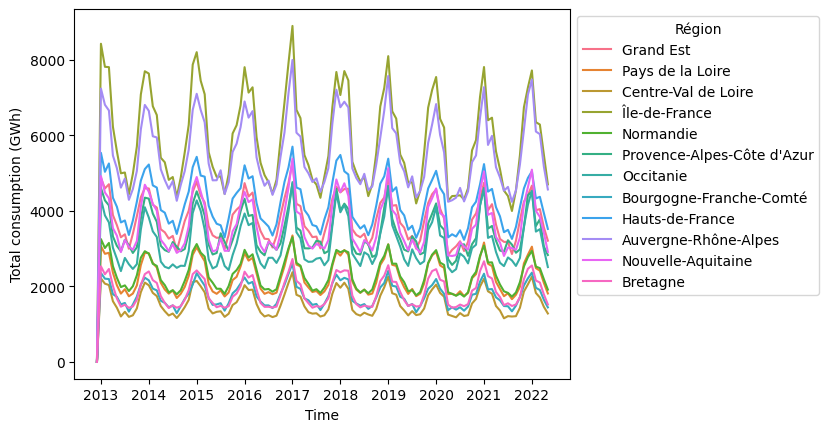

In [6]:
def retrieve_column_positional_information(df_column) -> dict:    
    """
    Function that returns a dictionary of years and associated positions in a column of a dataframe.
    params :
        - df_column : dataframe to explore
    return : dictionary of years and associated positions
    """
    positions = dict()
    for i in range(len(df_column)):
        year = str(df_column[i])[0:4]
        if year not in positions and year != "2012":
            positions[year] = math.ceil(i/12)
    return positions
                
# Aggregation of years and months and call to retrieve_column_positional_information to exploit a seaborn plot
consommation_df["AnneeMois"] = consommation_df["Annee"].astype(str) + "-" + consommation_df["Mois"].astype(str)
positions = retrieve_column_positional_information(consommation_df["AnneeMois"])
index, labels = list(positions.values()), list(positions.keys())

# Display of the plot (with modification of the x axis and the position of the legend)
lineplot_axis = sns.lineplot(data=consommation_df, x="AnneeMois", y="Consommation totale (GWh)", hue="Région", errorbar=None)
plt.xticks(index, labels)
lineplot_axis.set(xlabel="Time", ylabel="Total consumption (GWh)")
sns.move_legend(lineplot_axis, "upper left", bbox_to_anchor=(1, 1))

### 2.2 Pivot

Recovery in a dataframe of the daily consumption (in GWh) with one column per region

In [7]:
%%sql
DROP TABLE IF EXISTS consommation CASCADE;
CREATE TABLE consommation as (SELECT "Date - Heure", SUM(CASE WHEN Région='Île-de-France' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Île-de-France", 
    SUM(CASE WHEN Région='Normandie' THEN "Consommation (MW)" / 2000  ELSE 0 END) "Normandie",
    SUM(CASE WHEN Région='Bourgogne-Franche-Comté' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Bourgogne-Franche-Comté",
    SUM(CASE WHEN Région='Nouvelle-Aquitaine' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Nouvelle-Aquitaine",
    SUM(CASE WHEN Région='Pays de la Loire' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Pays de la Loire",
    SUM(CASE WHEN Région='Provence-Alpes-Côte d''Azur' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Provence-Alpes-Côte d''Azur",
    SUM(CASE WHEN Région='Centre-Val de Loire' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Centre-Val de Loire",
    SUM(CASE WHEN Région='Grand Est' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Grand Est",
    SUM(CASE WHEN Région='Bretagne' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Bretagne",
    SUM(CASE WHEN Région='Hauts-de-France' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Hauts-de-France",
    SUM(CASE WHEN Région='Auvergne-Rhône-Alpes' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Auvergne-Rhône-Alpes",
    SUM(CASE WHEN Région='Occitanie' THEN "Consommation (MW)" / 2000 ELSE 0 END) "Occitanie" from eco_2_mix_table GROUP BY "Date - Heure");

,Count
0,165003


### 2.3 Sliding window

#### 2.3.1 Retrieve the dataframe associated with the request

Use a CTE to retrieve the daily consumption. Then use a sliding window thanks to the `SUM()` windowing function for each month (delimited by the `PARTITION BY` in the `OVER()`).

In [8]:
%%sql
evolution_df << WITH cteDay AS(
    SELECT date_trunc('day', "DATE - HEURE") AS date,
    SUM("Consommation (MW)") as consommationJournaliere 
    FROM eco_2_mix_table GROUP BY date
)
SELECT date, SUM(consommationJournaliere) 
    OVER (
        PARTITION BY date_trunc('month', date) ORDER BY date
    ) as evolutionConsommation
FROM cteDay ORDER BY date;

Returning data to local variable evolution_df


#### 2.3.2 Results visualisation

C:\Users\marin\AppData\Local\Temp\ipykernel_2532\3458475912.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.pivot will be keyword-only.
  evolutionDf_aggregate_wide = evolutionDf_aggregate.pivot("month", "year", "evolutionConsommation")


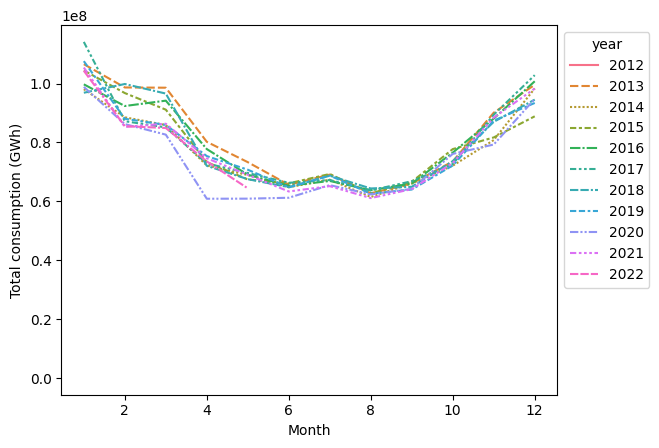

In [9]:

# Aggregation of months and pivot to operate a seaborn plot
evolution_df["date"] = pd.to_datetime(evolution_df["date"])
evolutionDf_aggregate = evolution_df.groupby(evolution_df["date"].dt.to_period("M")).last()
evolutionDf_aggregate["year"] = evolutionDf_aggregate["date"].dt.year
evolutionDf_aggregate["month"] = evolutionDf_aggregate["date"].dt.month
evolutionDf_aggregate = evolutionDf_aggregate.drop("date", axis=1)
evolutionDf_aggregate_wide = evolutionDf_aggregate.pivot("month", "year", "evolutionConsommation")

# Display of the plot (with modification of the position of the legend)
lineplot_axis = sns.lineplot(data=evolutionDf_aggregate_wide)
lineplot_axis.set(xlabel="Month", ylabel="Total consumption (GWh)")
sns.move_legend(lineplot_axis, "upper left", bbox_to_anchor=(1, 1))

### 2.4 Variation

#### 2.4.1 Retrieving the dataframe associated with the request

Use of a first CTE to calculate the consumption on a date. The second CTE is used to calculate the difference in consumption between two consecutive days. Finally, the result is filtered so as to keep only the 20 days where consumption has increased (sorted in a descending manner). 

In [10]:
%%sql
difference_df << WITH cteDate as (
    SELECT date_trunc('day', "DATE - HEURE") as date, SUM("Consommation (MW)") as consommationDate
    FROM eco_2_mix_table GROUP BY DATE
),
cteDifference as (
    SELECT d2.date as datePrecedente, d1.date as dateActuelle, ABS(d1.consommationDate-d2.consommationDate) as difference
    FROM cteDate d1, cteDate d2 where d2.date = d1.date-1
)
SELECT * FROM cteDifference ORDER BY difference DESC LIMIT 20

Returning data to local variable difference_df


#### 2.4.2 Results visualisation

[Text(0.5, 0, 'Month'), Text(0, 0.5, 'Cumulated difference (MW)')]

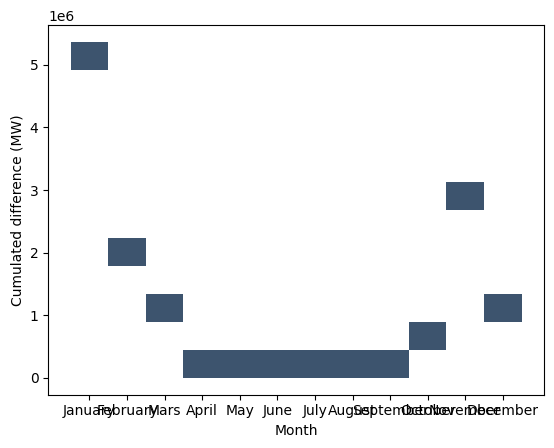

In [11]:
def create_density_data_frame(df: pd.DataFrame) -> pd.DataFrame:
    """Function that returns a dataframe with the consumption difference density data for each month
    Args:
        df (pd.DataFrame): dataframe containing consumption data
    Returns:
        pd.DataFrame: dataframe with consumption difference density data for each month
    """
    mois = ["January", "February", "Mars", "April", "May", "June", "July", "August", "September", "October", "November", "December"]
    density_df = pd.DataFrame({"Mois": mois, "differenceCumulee": 0})
    for i in range(df.shape[0]):
        # Retrieve the difference value and add it to the corresponding month
        density_df.loc[df.loc[i, "month"]-1, "differenceCumulee"] += df.loc[i, "difference"]
    return density_df

# Consideration of the current date as a reference date and construction of a dataframe accumulating the differences for each month
difference_df["dateActuelle"] = pd.to_datetime(difference_df["dateActuelle"])
difference_df["month"] = difference_df["dateActuelle"].dt.month
difference_df = difference_df.drop(["dateActuelle", "datePrecedente"], axis=1)
new_df = create_density_data_frame(difference_df)

# Display of the plot (with modification of the position of the legend)
histplot_axis = sns.histplot(data=new_df, x="Mois", y="differenceCumulee", bins=12)
histplot_axis.set(xlabel="Month", ylabel="Cumulated difference (MW)")


### 2.5 Cumulated quantity

The first CTE (cteDay) is mainly useful to avoid repetitions per hour and to optimize the query. cteConso is then used to obtain the evolution of the consumption per day over a year. Then, cteAnnee allows to add the production per year
and cteDepassement allows to obtain all the dates from which the resources are exceeded. Finally, the final select allows to limit the display to the first dates of overrun per year (avoid having the 2nd of April 2013 and the following days in the year)

In [12]:
%%sql
WITH cteDay AS(
    SELECT date_trunc('day', "DATE - HEURE") AS date, SUM("Consommation (MW)") as consommationJournaliere 
    FROM eco_2_mix_table GROUP BY date
),
cteConsommation as (
    SELECT DATE, SUM(consommationJournaliere) 
    OVER (
        PARTITION BY date_trunc('year', date) ORDER BY date) as evolutionConsommation 
    FROM cteDay ORDER BY date
),
cteAnnee as (
    SELECT year("DATE - HEURE") as Annee, SUM("Production instantanée") as productionAnnee 
    FROM eco_2_mix_table GROUP BY Annee
),
cteDepassement as(
    SELECT *, (productionAnnee-evolutionConsommation) as productionRestante 
    FROM cteConsommation, cteAnnee WHERE Annee = year(date) AND productionRestante < 0
)
SELECT DATE FROM cteDepassement WHERE productionRestante IN (SELECT MAX(productionRestante) FROM cteDepassement GROUP BY Annee)

,date
0,2012-12-31
1,2013-02-26
2,2014-03-01
3,2015-04-07
4,2016-04-09
5,2017-04-17
6,2018-04-04
7,2019-04-10
8,2020-04-06
9,2021-04-10


### 2.6 Fixed point calculation

In [13]:
%%sql
WITH RECURSIVE
    numbered AS (
        SELECT
            "Région",
            "Date - Heure",
            "Consommation (MW)",
            ROW_NUMBER() OVER (ORDER BY "Région", "Date - Heure") AS row
        FROM eco_2_mix_table
    ),
    recurse(row, "Région", "Consommation (MW)", chainLength) AS (
        SELECT
            row,
            "Région",
            "Consommation (MW)",
            0 AS chainLength
        FROM numbered
        UNION ALL
        SELECT
            current.row,
            current."Région",
            current."Consommation (MW)",
            previous.chainLength + 1
        FROM recurse previous
        JOIN
        numbered current ON previous.row + 1 = current.row
            AND previous."Région" = current."Région"
            AND current."Consommation (MW)" > previous."Consommation (MW)"
    ),
    sequencesRanked AS (
        SELECT *,
               RANK() OVER (ORDER BY chainLength DESC) AS rank
        FROM recurse
        ORDER BY rank
        LIMIT 3
    )
SELECT
    MIN(n."Date - Heure") AS "Date - Heure",
    AGE(FIRST(n."Date - Heure"), LAST(n."Date - Heure")) AS "Durée",
    s."Région" AS "Région",
    STRING_AGG(n."Consommation (MW)", ', ') AS "Séquence (MW)",
    s.rank AS "Rang"
FROM
    sequencesRanked s, numbered n
WHERE
    n.row <= s.row
  AND n.row >= (s.row - s.chainLength)
GROUP BY s.row, s."Région", s.rank
ORDER BY s.rank;

,Date - Heure,Durée,Région,Séquence (MW),Rang
0,2016-07-18 01:30:00,0 days 11:00:00,Île-de-France,"8088.0, 7993.0, 7978.0, 7945.0, 7902.0, 7879.0...",1
1,2016-07-18 02:00:00,0 days 10:30:00,Île-de-France,"8088.0, 7993.0, 7978.0, 7945.0, 7902.0, 7879.0...",2
2,2019-07-11 02:00:00,0 days 10:30:00,Île-de-France,"7868.0, 7765.0, 7752.0, 7748.0, 7747.0, 7678.0...",2


### 2.7 Cube building

A first CTE retrieves the consumption data and retrieves the zones (NW, NE, SW, SE and IdF) rather than the regions. The next query builds the cube using `ROLLUP`.

In [14]:
%%sql
WITH cteZone AS(
  SELECT "Date - Heure",
  (CASE
    WHEN Région='Normandie' THEN 'NO'
    WHEN Région='Bourgogne-Franche-Comté' THEN 'NE'
    WHEN Région='Nouvelle-Aquitaine' THEN 'SO'
    WHEN Région='Pays de la Loire' THEN 'NO'
    WHEN Région='Provence-Alpes-Côte d''Azur' THEN 'SE'
    WHEN Région='Centre-Val de Loire' THEN 'NO'
    WHEN Région='Grand Est' THEN 'NE'
    WHEN Région='Bretagne' THEN 'NO'
    WHEN Région='Hauts-de-France' THEN 'NO'
    WHEN Région='Auvergne-Rhône-Alpes' THEN 'SE'
    WHEN Région='Occitanie' THEN 'SO'
    WHEN Région='Île-de-France' THEN 'Idf'
  END) AS zone,
  "Consommation (MW)"
  FROM eco_2_mix_table
)

SELECT
  year("Date - Heure") AS Annee,
  month("Date - Heure") AS Mois,
  day("Date - Heure") AS Jour,
  zone,
  SUM("Consommation (MW)" / 2000) AS consommation_GWh
FROM cteZone
GROUP BY ROLLUP (year("Date - Heure"), month("Date - Heure"), day("Date - Heure"), zone)

,Annee,Mois,Jour,zone,consommation_GWh
0,NaN,NaN,NaN,None,4.453160e+06
1,2012.0,NaN,NaN,None,2.983100e+01
2,2013.0,NaN,NaN,None,4.921014e+05
3,2018.0,NaN,NaN,None,4.755241e+05
4,2019.0,NaN,NaN,None,4.704801e+05
...,...,...,...,...,...
20755,2022.0,3.0,10.0,SE,3.445700e+02
20756,2016.0,12.0,8.0,NO,5.181580e+02
20757,2014.0,4.0,25.0,NO,3.920850e+02
20758,2017.0,4.0,14.0,NO,3.948085e+02


## 3. From the transit area to the warehouse

## 3.1 Integration of a new dataset

### Dataframe cleaning

The CSV is loaded as a pandas dataframe so that unnecessary columns can be easily removed. Then a table is created from this dataframe and the type of the `Date` column is changed to `TIMESTAMP` so that operators such as `year()` can be applied to it.

In [15]:
# Pandas dataframe creation
synop_df = pd.read_csv("donnees-synop-essentielles-omm.csv", sep=";")
columnsToDrop = synop_df.columns.values.tolist()
columnsToKeep = ['Date','region (name)', 'Température (°C)', 'Température minimale sur 24 heures (°C)', 'Température maximale sur 24 heures (°C)']
columnsToDrop = [column for column in columnsToDrop if column not in columnsToKeep]
synop_df = synop_df.drop(columnsToDrop, axis=1)

# Delete the SQL table if it already exists
%sql DROP TABLE IF EXISTS synop_table CASCADE;

# Transformation of the dataframe into a SQL table
%sql CREATE TABLE synop_table AS (SELECT * FROM synop_df);

# Conversion of character string (ISO 8601) to SQL Timestamp
%sql ALTER TABLE synop_table ALTER COLUMN \"Date\" TYPE TIMESTAMP;

""


### Transformation of statements into daily statements and alignment

A view is created for each table to transform it into daily records. Then, the daily records are merged into a single dataframe with a join on `Date` and `Region` (so that only rows with actual records are proposed).

In [16]:
%%sql
DROP VIEW IF EXISTS eco_2_mix_view_by_day CASCADE;
CREATE VIEW eco_2_mix_view_by_day AS(
    SELECT date_trunc('day', "DATE - HEURE") AS date,
    "Région",
    AVG("Thermique (MW)") AS "Thermique (MW)", 
    AVG("Nucléaire (MW)") AS "Nucléaire (MW)",
    AVG("Eolien (MW)") AS "Eolien (MW)",
    AVG("Solaire (MW)") AS "Solaire (MW)",
    AVG("Pompage (MW)") AS "Pompage (MW)",
    AVG("Bioénergies (MW)") AS "Bioénergies (MW)",
    AVG("Ech. physiques (MW)") AS "Ech. physiques (MW)",
    SUM("Consommation (MW)") AS consommationJournaliere 
    FROM eco_2_mix_table GROUP BY date, "Région" ORDER BY date
);
DROP VIEW IF EXISTS synop_view_by_day CASCADE;
CREATE VIEW synop_view_by_day AS(
    SELECT date_trunc('day', "Date") AS date,
    "region (name)" AS Région,
    AVG("Température (°C)") AS "Température (°C)",
    ANY_VALUE("Température minimale sur 24 heures (°C)") AS "Température minimale sur 24 heures (°C)",
    ANY_VALUE("Température maximale sur 24 heures (°C)") AS "Température maximale sur 24 heures (°C)"
    FROM synop_table GROUP BY date, "Région" ORDER BY date
);
DROP TABLE IF EXISTS eco_2_mix_synop_table CASCADE;
CREATE TABLE eco_2_mix_synop_table AS(
    SELECT eco_2_mix_view_by_day.date AS date,
        eco_2_mix_view_by_day."Région" AS "Région",
        eco_2_mix_view_by_day."Thermique (MW)" AS "Thermique (MW)",
        eco_2_mix_view_by_day."Nucléaire (MW)" AS "Nucléaire (MW)",
        eco_2_mix_view_by_day."Eolien (MW)" AS "Eolien (MW)",
        eco_2_mix_view_by_day."Solaire (MW)" AS "Solaire (MW)",
        eco_2_mix_view_by_day."Pompage (MW)" AS "Pompage (MW)",
        eco_2_mix_view_by_day."Bioénergies (MW)" AS "Bioénergies (MW)",
        eco_2_mix_view_by_day."Ech. physiques (MW)" AS "Ech. physiques (MW)",
        eco_2_mix_view_by_day.consommationJournaliere AS consommationJournaliere,
        synop_view_by_day."Température (°C)" AS "Température (°C)",
        synop_view_by_day."Température minimale sur 24 heures (°C)" AS "Température minimale sur 24 heures (°C)",
        synop_view_by_day."Température maximale sur 24 heures (°C)" AS "Température maximale sur 24 heures (°C)" 
    FROM eco_2_mix_view_by_day 
    JOIN synop_view_by_day 
    ON eco_2_mix_view_by_day.date = synop_view_by_day.date 
    AND eco_2_mix_view_by_day."Région" = synop_view_by_day."Région"
);
SELECT * FROM eco_2_mix_synop_table;

,date,Région,Thermique (MW),Nucléaire (MW),Eolien (MW),Solaire (MW),Pompage (MW),Bioénergies (MW),Ech. physiques (MW),consommationJournaliere,Température (°C),Température minimale sur 24 heures (°C),Température maximale sur 24 heures (°C)
0,2012-12-31,Île-de-France,685.000000,NaN,16.000000,0.000000,NaN,142.000000,8289.000000,9134.0,11.000000,NaN,NaN
1,2012-12-31,Grand Est,319.000000,9137.000000,1109.000000,0.000000,0.000000,57.000000,-7102.000000,4943.0,9.140000,NaN,NaN
2,2012-12-31,Hauts-de-France,828.000000,4499.000000,1115.000000,0.000000,NaN,69.000000,-525.000000,5989.0,10.000000,NaN,NaN
3,2012-12-31,Occitanie,78.000000,2497.000000,367.000000,0.000000,-13.000000,81.000000,1273.000000,5228.0,10.714286,NaN,NaN
4,2012-12-31,Centre-Val de Loire,90.000000,9085.000000,508.000000,0.000000,NaN,25.000000,-7267.000000,2476.0,8.050000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
329690,2022-01-29,Hauts-de-France,1217.375000,3629.083333,3288.750000,9.750000,0.000000,115.020833,-2029.416667,299183.0,9.750000,NaN,NaN
329691,2022-01-29,Normandie,367.708333,8925.729167,514.395833,12.875000,NaN,69.020833,-6352.187500,170491.0,9.225000,NaN,NaN
329692,2022-02-24,Centre-Val de Loire,84.145833,9498.958333,545.645833,64.270833,NaN,60.604167,-7602.604167,128245.0,10.950000,NaN,NaN
329693,2022-02-24,Île-de-France,399.479167,NaN,56.750000,11.104167,NaN,152.937500,8539.270833,440035.0,4.600000,NaN,NaN


### 3.2 Design of a multi-dimensional database

**/!\This request is very resource intensive. It is recommended to run it with a small dataset.**

The following code is divided into several steps:
- Creation of the fact and dimension tables
- Filling the dimension tables with the `eco_2_mix_synop_table` and a sequence (for the primary key as a surrogate key)
- Filling the fact table with the `eco_2_mix_synop_table` and joins on the dimension tables

#### Tables design

In [17]:
%%sql
DROP TABLE IF EXISTS energy_table CASCADE;
DROP TABLE IF EXISTS time_table CASCADE;
DROP TABLE IF EXISTS geography_table CASCADE;
DROP TABLE IF EXISTS temperature_table CASCADE;

CREATE TABLE time_table (
    tempsId INTEGER PRIMARY KEY,
    jour INTEGER,
    mois INTEGER,
    saison VARCHAR(10),
    annee INTEGER,
);

CREATE TABLE geography_table (
    geographieId INTEGER PRIMARY KEY,
    region VARCHAR(255),
    quart VARCHAR(2),
    pays VARCHAR(6) DEFAULT 'France',
);

CREATE TABLE temperature_table (
    temperatureId INTEGER PRIMARY KEY,
    degre INTEGER,
    intervalle VARCHAR(10),
);

CREATE TABLE energy_table (
    tempsId INTEGER,
    geographieId INTEGER,
    temperatureId INTEGER,
    consommation_regionale INTEGER,
    production_thermique INTEGER,
    production_nucleaire INTEGER,
    production_eolien INTEGER,
    production_solaire INTEGER,
    production_pompage INTEGER,
    production_bioenergies INTEGER,
    production_echanges_physiques INTEGER,
    FOREIGN KEY (tempsId) REFERENCES time_table (tempsId),
    FOREIGN KEY (geographieId) REFERENCES geography_table (geographieId),
    FOREIGN KEY (temperatureId) REFERENCES temperature_table (temperatureId)
);

""


#### Data warehouse supply

In [18]:
%%sql
CREATE SEQUENCE IF NOT EXISTS time_table_serial START 1;
INSERT INTO time_table (tempsId, jour, mois, saison, annee)
SELECT 
    nextval('time_table_serial'),
    day("date"),
    month("date"), 
    (CASE
    WHEN month("date") in (12, 1, 2) then 'winter'
    WHEN month("date") in (3, 4, 5) then 'spring'
    WHEN month("date") in (6, 7, 8) then 'summer'
    WHEN month("date") in (9, 10, 11) then 'autumn'
    END) as Saison,
    year("date")
FROM eco_2_mix_synop_table;

CREATE SEQUENCE IF NOT EXISTS geography_table_serial START 1;
INSERT INTO geography_table (geographieId, region, quart)
SELECT 
    nextval('geography_table_serial'),
    Région,
    (CASE
        WHEN Région='Normandie' THEN 'NO'
        WHEN Région='Bourgogne-Franche-Comté' THEN 'NE'
        WHEN Région='Nouvelle-Aquitaine' THEN 'SO'
        WHEN Région='Pays de la Loire' THEN 'NO'
        WHEN Région='Provence-Alpes-Côte d''Azur' THEN 'SE'
        WHEN Région='Centre-Val de Loire' THEN 'NO'
        WHEN Région='Grand Est' THEN 'NE'
        WHEN Région='Bretagne' THEN 'NO'
        WHEN Région='Hauts-de-France' THEN 'NO'
        WHEN Région='Auvergne-Rhône-Alpes' THEN 'SE'
        WHEN Région='Occitanie' THEN 'SO'
        WHEN Région='Île-de-France' THEN 'Idf'
    END)
FROM eco_2_mix_synop_table;

CREATE SEQUENCE IF NOT EXISTS temperature_table_serial START 1;
INSERT INTO temperature_table (temperatureId, degre, intervalle)
SELECT 
    nextval('temperature_table_serial'),
    "Température (°C)",
    (CASE
        WHEN "Température (°C)" < 15 THEN 'cold'
        WHEN "Température (°C)" < 30 THEN 'temperate'
        ELSE 'warm'
    END)
FROM eco_2_mix_synop_table;

INSERT INTO energy_table (tempsId, geographieId, temperatureId, consommation_regionale,
                          production_thermique, production_nucleaire, production_eolien,
                          production_solaire, production_pompage, production_bioenergies,
                          production_echanges_physiques)
SELECT
    time.tempsId,
    geography.geographieId,
    temperature.temperatureId,
    eco_2_mix_synop_table."consommationJournaliere",
    eco_2_mix_synop_table."Thermique (MW)",
    eco_2_mix_synop_table."Nucléaire (MW)",
    eco_2_mix_synop_table."Eolien (MW)",
    eco_2_mix_synop_table."Solaire (MW)",
    eco_2_mix_synop_table."Pompage (MW)",
    eco_2_mix_synop_table."Bioénergies (MW)",
    eco_2_mix_synop_table."Ech. physiques (MW)"
FROM eco_2_mix_synop_table, time_table time, geography_table geography, temperature_table temperature
WHERE time.jour = day(eco_2_mix_synop_table."date") AND time.mois = month(eco_2_mix_synop_table."date") AND time.annee = year(eco_2_mix_synop_table."date")
AND geography.region = eco_2_mix_synop_table."Région"
AND temperature.degre = eco_2_mix_synop_table."Température (°C)";

(duckdb.IOException) IO Error: Could not read file "c:\Users\marin\Documents\Personnel\Travail\Polytech\S7\SQL_avance_et_entrepots_de_donnees\TP\GIT\eco2mix.db.tmp\duckdb_temp_storage-2.tmp" (error in ReadFile(location: 618921984, nr_bytes: 262144)): Fin de fichier atteinte.

[SQL: INSERT INTO energy_table (tempsId, geographieId, temperatureId, consommation_regionale,
                          production_thermique, production_nucleaire, production_eolien,
                          production_solaire, production_pompage, production_bioenergies,
                          production_echanges_physiques)
SELECT
    time.tempsId,
    geography.geographieId,
    temperature.temperatureId,
    eco_2_mix_synop_table."consommationJournaliere",
    eco_2_mix_synop_table."Thermique (MW)",
    eco_2_mix_synop_table."Nucléaire (MW)",
    eco_2_mix_synop_table."Eolien (MW)",
    eco_2_mix_synop_table."Solaire (MW)",
    eco_2_mix_synop_table."Pompage (MW)",
    eco_2_mix_synop_table."Bioénergies (MW)